In [1]:
import numpy as np
import pandas as pd

# for plotting the heatmap
import matplotlib.pyplot as plt

# recommendation
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler

print(pd. __version__)

1.5.3


In [2]:
import psycopg2
# Establish connection
conn = psycopg2.connect(dbname="postgres", user="postgres", password="postgres", host="localhost", port="5432")

# SQL query
query = """
    SELECT id, model_year, make, car_model, vehicle_class, engine_size, cylinders, transmission,
           fuel_type, city, highway, combined, combined_mpg, "CO2_Emission",
           motor, "city_kWh", "highway_kWh", "combined_kWh", range, recharge_time, 
           fuel_type2, range2, "combined_PHEV", vehicle_type
    FROM datamining_carinfomodel;
"""
#    WHERE model_year > 2015;

#df = pd.read_csv("../data/Conventional/MY2015-2019 Fuel Consumption Ratings.csv")
df = pd.read_sql_query(query, conn)

# Store the row IDs separately for future reference if needed
# original_row_ids = df['id']

C:\Users\nayeem\AppData\Local\Temp\ipykernel_14388\3447587748.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


In [3]:
# # check null
# df.isnull().sum()

# # check rows
# df.shape

# # check duplicate values
# duplicated_rows = df.duplicated(subset = df.columns[1:])

# # Display rows with duplicated values
# print(df.columns[1:])
# print(duplicated_rows)

In [4]:
# # Find correlation matrix
# import seaborn as sns

# # df_n = df.mode(numeric_only=True, dropna=True)

# correlation_matrix = df.corr()

# # Plot correlation matrix as a heatmap
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
# plt.title('Correlation Matrix')
# plt.ylabel('Variables')
# # TODO figure out text in th cells
# # c = plt.pcolor(correlation_matrix, edgecolors='k', linewidths=4, cmap='RdBu', vmin=0.0, vmax=1.0)
# # plt.colorbar(c)
# plt.show()

In [5]:
# Saving IDs
ids = df['id'].tolist()

# Preprocessing

# Each variable is converted in as many 0/1 variables as there are different values.
# Columns in the output are each named after a value; if the input is a DataFrame, the name of the original variable is prepended to the value.
transforemer = pd.get_dummies(df)
scaler = MinMaxScaler()
scale_columns = ['engine_size', 'cylinders', 'city' , 'highway','combined', 'combined_mpg', 'CO2_Emission']
transforemer[scale_columns] = scaler.fit_transform(transforemer[scale_columns])
transforemer.fillna(0, inplace=True)

# Adding IDs back
transforemer['id'] = ids

# print(transforemer.head(10))

In [6]:
recommended_ids = [];

def recommend_similar_cars(source_car_id, user_weights, filter_carbon_emission=False):
    source_car = df[df.index == source_car_id].iloc[0]  # Get the source car from the DataFrame using its ID

    # Adjust weights based on user input
    weighted_data = transforemer.copy()
    weighted_data[['engine_size', 'cylinders', 'city', 'highway', 'combined', 'combined_mpg', 'CO2_Emission']] *= user_weights

    # Calculate similarity scores based on adjusted weights
    similarity_scores = cosine_similarity(weighted_data.values, transforemer.values)

    NUMBER_OF_RESULTS = 50

    # Get indices of top similar cars
    # Exclude self-similarity and get top <NUMBER_OF_RESULTS> similar cars
    top_similar_indices = similarity_scores[source_car_id].argsort()[::-1][1:NUMBER_OF_RESULTS+1]
    
    print(len(top_similar_indices))

    # Filter and display recommended cars
    recommended_cars = {}
    for idx in top_similar_indices:
        similar_car = df.iloc[idx]

        # Skip if similar car has the same model as the source car
        if similar_car['car_model'] == source_car['car_model']:
            continue

        # Filter similar cars based on carbon emissions if filter_carbon_emission is True
        if filter_carbon_emission and similar_car['CO2_Emission'] > source_car['CO2_Emission']:
            continue  # Skip if similar car has higher emissions

        if filter_carbon_emission:
        # Keep only the car with the least carbon emissions for each model
          if similar_car['car_model'] not in recommended_cars or similar_car['CO2_Emission'] < recommended_cars[similar_car['car_model']][3]:
            recommended_cars[similar_car['car_model']] = (similar_car['make'], similar_car['Model'], similar_car['model_year'], similar_car['CO2_Emission'])
        else:
          if similar_car['car_model'] not in recommended_cars or similar_car['model_year'] > recommended_cars[similar_car['car_model']][3]:
                recommended_cars[similar_car['car_model']] = (similar_car['make'], similar_car['car_model'], similar_car['model_year'], similar_car['CO2_Emission'])

    return list(recommended_cars.values())

In [ ]:
# Example usage:
user_weights = {'engine_size': 0.6, 'cylinders': 0.55, 'city': 0.85, 'highway': 0.8, 'combined': 0.6, 'combined_mpg': 0.85, 'CO2_Emission': 0.1}
source_car_id = 100
filter_carbon_emission = True

recommended_cars = recommend_similar_cars(source_car_id, user_weights)

print(f"\nRecommendations for Source Car: {df.iloc[source_car_id]['make']} {df.iloc[source_car_id]['car_model']} ({df.iloc[source_car_id]['model_year']}) CO2 emissions: {df.iloc[source_car_id]['CO2_Emission']} g/km")
print("Similar cars with CO2 emissions (sorted by ascending order):")
recommended_cars_sorted = sorted(recommended_cars, key=lambda x: x[3])  # Sort recommended cars by CO2 emissions

for idx, rec in enumerate(recommended_cars_sorted):
    print(f"{idx}. {rec[0]} {rec[1]} ({rec[2]}), CO2 emissions: {rec[3]} g/km")

 car 1 : engine_size     0.564103
cylinders       0.428571
city            0.532423
highway         0.615385
combined        0.578723
combined_mpg    0.098361
CO2_Emission    0.639810
Name: 1334, dtype: float64
 car 2 : engine_size     0.205128
cylinders       0.142857
city            0.252560
highway         0.230769
combined        0.251064
combined_mpg    0.311475
CO2_Emission    0.360190
Name: 5001, dtype: float64
 car 1 : [0.56410256 0.42857143 0.53242321 0.61538462 0.5787234  0.09836066
 0.63981043 0.56410256]
 car 2 : [0.20512821 0.14285714 0.25255973 0.23076923 0.25106383 0.31147541
 0.36018957 0.20512821]


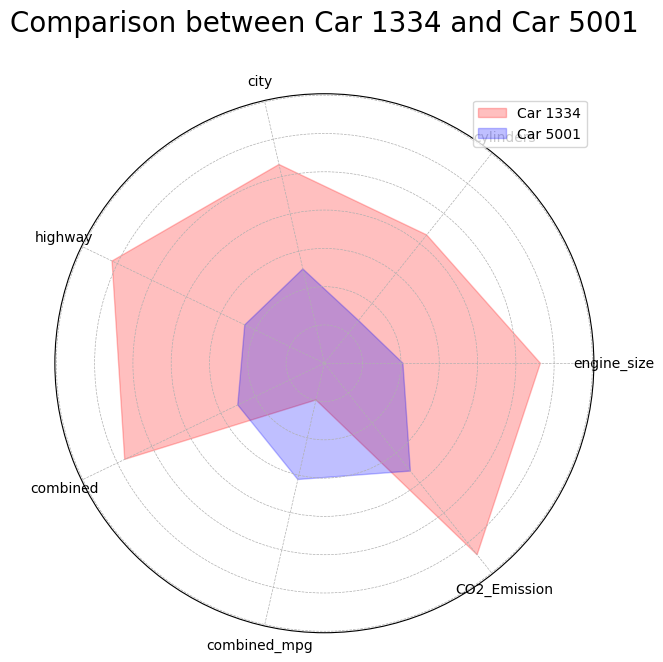

In [27]:
# SPIDER chart

def plot_radar_chart(car1_id, car2_id, data):
    attributes = ['engine_size' ,'cylinders' , 'city' , 'highway' ,'combined' , 'combined_mpg' , 'CO2_Emission']

    # Get data for car1 and car2
    car1_data = data[data.index == car1_id][attributes].iloc[0]
    car2_data = data[data.index == car2_id][attributes].iloc[0]

    print(f" car 1 : {car1_data}")
    print(f" car 2 : {car2_data}")

    # Radar chart attributes
    labels = np.array(attributes)
    num_vars = len(labels)

    # Compute angle for each axis
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    # Complete the loop
    car1_data = np.concatenate((car1_data,[car1_data[0]]))
    car2_data = np.concatenate((car2_data,[car2_data[0]]))
    angles += angles[:1]

    # Plot
    fig, ax = plt.subplots(figsize=(7, 7), subplot_kw=dict(polar=True))

    ax.fill(angles, car1_data, color='red', alpha=0.25, label=f'Car {car1_id}')
    ax.fill(angles, car2_data, color='blue', alpha=0.25, label=f'Car {car2_id}')

    # Add legend
    ax.legend(loc='upper right', fontsize='medium')

    # Add labels
    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(attributes)

    print(f" car 1 : {car1_data}")
    print(f" car 2 : {car2_data}")

    # Setting range for the radar chart
    ax.set_ylim(0, max(max(car1_data), max(car2_data)) * 1.1)

    # Adding title
    plt.title(f'Comparison between Car {car1_id} and Car {car2_id}', size=20, color='black', y=1.1)

    # Improve aesthetics
    plt.grid(True, linestyle='--', linewidth=0.5)

    plt.show()

# Example usage
# Assuming 'data' is a DataFrame containing the necessary information
# Replace 'data' with your actual DataFrame name
# Replace 'car1_id' and 'car2_id' with the IDs of the cars you want to compare
plot_radar_chart(1334, 5001, transforemer)


In [29]:
# ouput CSV ->
df.to_csv('merged_v1.csv', index=False) 

 car 1 : engine_size     0.0
cylinders       0.0
city            0.0
highway         0.0
combined        0.0
CO2_Emission    0.0
Name: 2, dtype: float64
 car 2 : engine_size     0.0
cylinders       0.0
city            0.0
highway         0.0
combined        0.0
CO2_Emission    0.0
Name: 500, dtype: float64
 car 1 : [0. 0. 0. 0. 0. 0. 0.]
 car 2 : [0. 0. 0. 0. 0. 0. 0.]


/var/folders/d4/shs1przn7kv14dtw8dyw_k680000gn/T/ipykernel_79973/2389434434.py:43: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(0, max(max(car1_data), max(car2_data)) * 1.1)


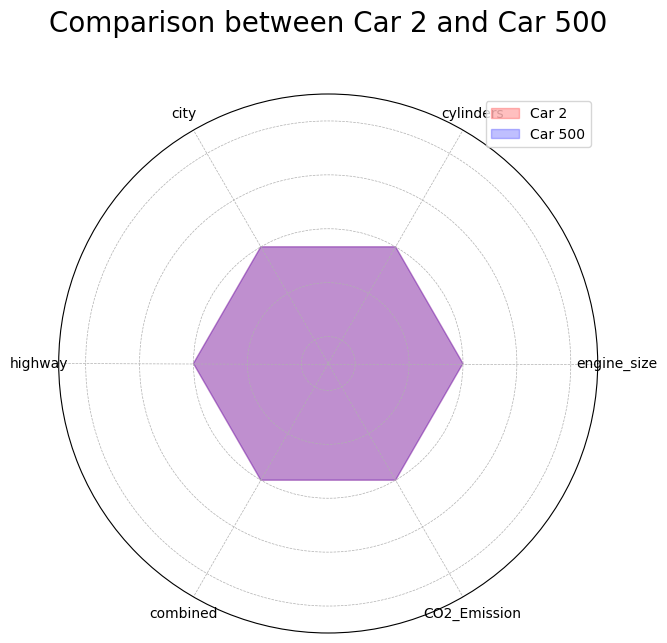

In [94]:
# SPIDER chart

def plot_radar_chart(car1_id, car2_id, data):
    attributes = ['motor' ,'range' , 'recharge_time' , 'range2' ,'combined' , 'CO2_Emission']

    # Get data for car1 and car2
    car1_data = data[data.index == car1_id][attributes].iloc[0]
    car2_data = data[data.index == car2_id][attributes].iloc[0]

    print(f" car 1 : {car1_data}")
    print(f" car 2 : {car2_data}")

    # Radar chart attributes
    labels = np.array(attributes)
    num_vars = len(labels)

    # Compute angle for each axis
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    # Complete the loop
    car1_data = np.concatenate((car1_data,[car1_data[0]]))
    car2_data = np.concatenate((car2_data,[car2_data[0]]))
    angles += angles[:1]

    # Plot
    fig, ax = plt.subplots(figsize=(7, 7), subplot_kw=dict(polar=True))

    ax.fill(angles, car1_data, color='red', alpha=0.25, label=f'Car {car1_id}')
    ax.fill(angles, car2_data, color='blue', alpha=0.25, label=f'Car {car2_id}')

    # Add legend
    ax.legend(loc='upper right', fontsize='medium')

    # Add labels
    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(attributes)

    print(f" car 1 : {car1_data}")
    print(f" car 2 : {car2_data}")

    # Setting range for the radar chart
    ax.set_ylim(0, max(max(car1_data), max(car2_data)) * 1.1)

    # Adding title
    plt.title(f'Comparison between Car {car1_id} and Car {car2_id}', size=20, color='black', y=1.1)

    # Improve aesthetics
    plt.grid(True, linestyle='--', linewidth=0.5)

    plt.show()

# Example usage
# Assuming 'data' is a DataFrame containing the necessary information
# Replace 'data' with your actual DataFrame name
# Replace 'car1_id' and 'car2_id' with the IDs of the cars you want to compare
plot_radar_chart(2, 500, transforemer)

##SPIDER END

In [91]:
###### DATA VISULAIZATION

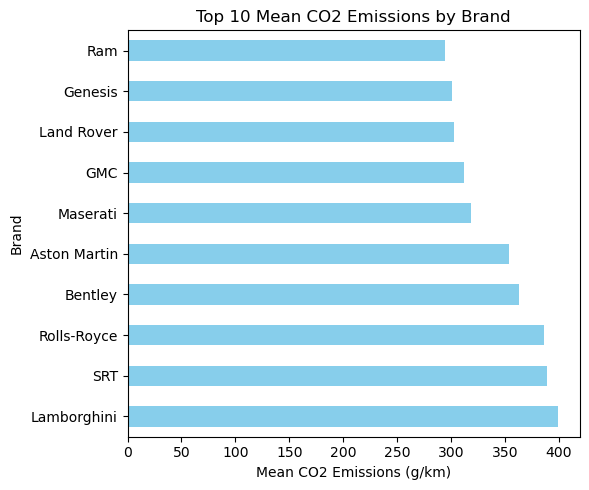

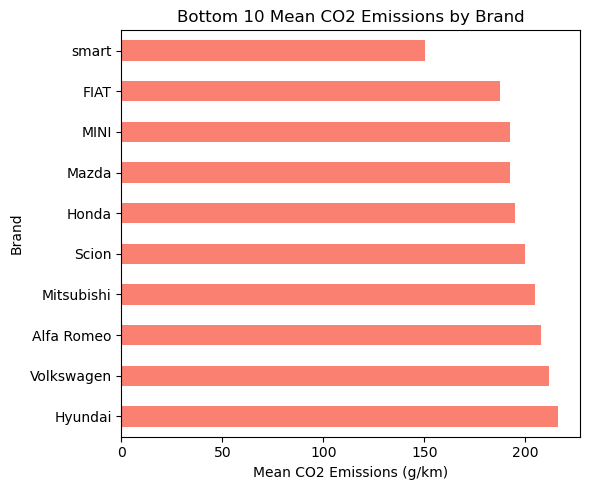

In [85]:
# First, let's calculate the mean CO2 emissions brand-wise
mean_co2_by_brand = df.groupby('make')['CO2_Emission'].mean()

# Now, let's sort the mean CO2 emissions in descending order
sorted_mean_co2 = mean_co2_by_brand.sort_values(ascending=False)

top_10 = sorted_mean_co2.head(10)
bottom_10 = sorted_mean_co2.tail(10)

# Plotting the horizontal bar graph for top 10
plt.figure(figsize=(6, 5))  # Set the figure size
top_10.plot(kind='barh', color='skyblue')  # Plotting the horizontal bar graph
plt.title('Top 10 Mean CO2 Emissions by Brand')
plt.xlabel('Mean CO2 Emissions (g/km)')
plt.ylabel('Brand')
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()  # Show the plot

# Plotting the horizontal bar graph for bottom 10
plt.figure(figsize=(6, 5))  # Set the figure size
bottom_10.plot(kind='barh', color='salmon')  # Plotting the horizontal bar graph
plt.title('Bottom 10 Mean CO2 Emissions by Brand')
plt.xlabel('Mean CO2 Emissions (g/km)')
plt.ylabel('Brand')
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()  # Show the plot

In [ ]:
# Group by 'Fuel type' and 'Model year', then calculate the average CO2 emissions
co2_emission_yearly = df.groupby(['fuel_type', 'model_year'])['CO2_Emission'].mean().reset_index()

# TODO think about the fuel_type_2

# Map fuel type codes to labels
fuel_type_labels = {'X': 'Regular gasoline', 'Z': 'Premium gasoline', 'D': 'Diesel', 'E': 'E85', 'N': 'Natural Gas'}
co2_emission_yearly['Fuel type'] = co2_emission_yearly['Fuel type'].map(fuel_type_labels)

# Pivot the DataFrame to have 'Fuel type' as columns
co2_emission_yearly_pivot = co2_emission_yearly.pivot(index='Model year', columns='Fuel type', values='CO2 emissions (g/km)')

# Plot the data
co2_emission_yearly_pivot.plot(kind='line', marker='o', figsize=(10, 6))
plt.title('Average CO2 Emissions by Fuel Type and Year')
plt.xlabel('Model Year')
plt.ylabel('Average CO2 Emissions (g/km)')
# plt.grid(True)
plt.legend(title='Fuel Type')
plt.tight_layout()
plt.show()

NameError: name 'data' is not defined